# Sentinel 2 cloud free best pixel WF

remove cloud and shadow from series of S2 ARD images

then mosaic them to create a best pixel image for given time period

# steps:

Run a pyeodh stac search for given time period


In [52]:
import pyeodh
import xarray as xr
import rioxarray
import os
from pathlib import Path
import requests
# pyeodh.set_log_level(10)
rc = pyeodh.Client().get_catalog_service()

thetford_pnt = {
    "coordinates": [
        [
            [0.08905898091569497, 52.69722175598818],
            [0.08905898091569497, 52.15527412683906],
            [0.9565339502005088, 52.15527412683906],
            [0.9565339502005088, 52.69722175598818],
            [0.08905898091569497, 52.69722175598818],
        ]
    ],
    "type": "Polygon",
}

items = rc.search(
    collections=["sentinel2_ard"],
    catalog_paths=["supported-datasets/ceda-stac-fastapi"],
    intersects=thetford_pnt,
    query=[
        "start_datetime>=2023-04-01",
        "end_datetime<=2023-06-30",
    ],
    limit=10,
)



For each item open `cog`, `cloud` and `valid` .tif assets and remove the cloud like this:


In [53]:
for item in items.get_limited()[0:1]:
    cloud_href = item.assets["cloud"].href
    valid_href = item.assets["valid_pixels"].href
    cog_href = item.assets["cog"].href
    item
    print(item.id, cloud_href, valid_href, cog_href, sep="\n")
    valid = rioxarray.open_rasterio(valid_href)
    cloud = rioxarray.open_rasterio(cloud_href)

    #Check if cog file exists locally, if not download it
    cog_filename = f"data/{Path(cog_href).name}"
    if not os.path.isfile(cog_filename):
        with requests.get(cog_href, stream=True) as r:
            r.raise_for_status()
            with open(cog_filename, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192): 
                    f.write(chunk)
    
    cog = rioxarray.open_rasterio(cog_filename)
    print("==" * 10)
    print("success")
    break
    


neodc.sentinel_ard.data.sentinel_2.2023.06.25.S2B_20230625_latn527lonw0007_T30UXD_ORB137_20230625114918_utm30n_osgb
https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/06/25/S2B_20230625_latn527lonw0007_T30UXD_ORB137_20230625114918_utm30n_osgb_clouds.tif
https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/06/25/S2B_20230625_latn527lonw0007_T30UXD_ORB137_20230625114918_utm30n_osgb_valid.tif
https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/06/25/S2B_20230625_latn527lonw0007_T30UXD_ORB137_20230625114918_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref.tif


RasterioIOError: HTTP response code: 404

In [4]:
result = valid + cloud

NameError: name 'valid' is not defined

In [4]:
# Set values greater than 1 to 0, others remain as 1
result = xr.where(result > 1, 0, 1)

In [6]:
# Multiply cog.tif by the result
# We need to expand the result to match the shape of cog
fin = cog * result.squeeze("band").expand_dims(band=cog.band)

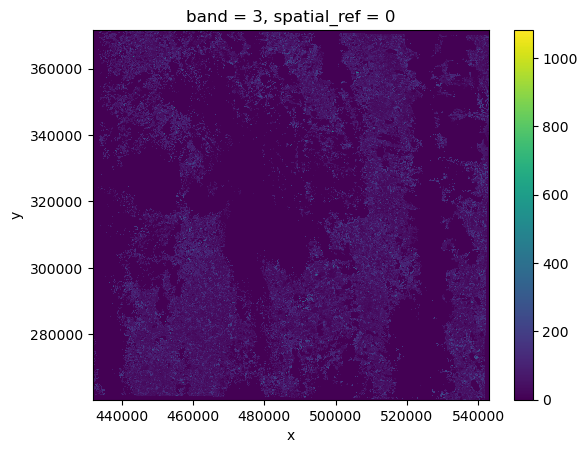

In [15]:
# We can plot individual bands using `isel`
fin.isel(band=2).plot.imshow()

# Composite creation

Can use pktools. It's an older code, but it checks out.

https://pktools.nongnu.org/html/pkcomposite.html


### 2023 06 10
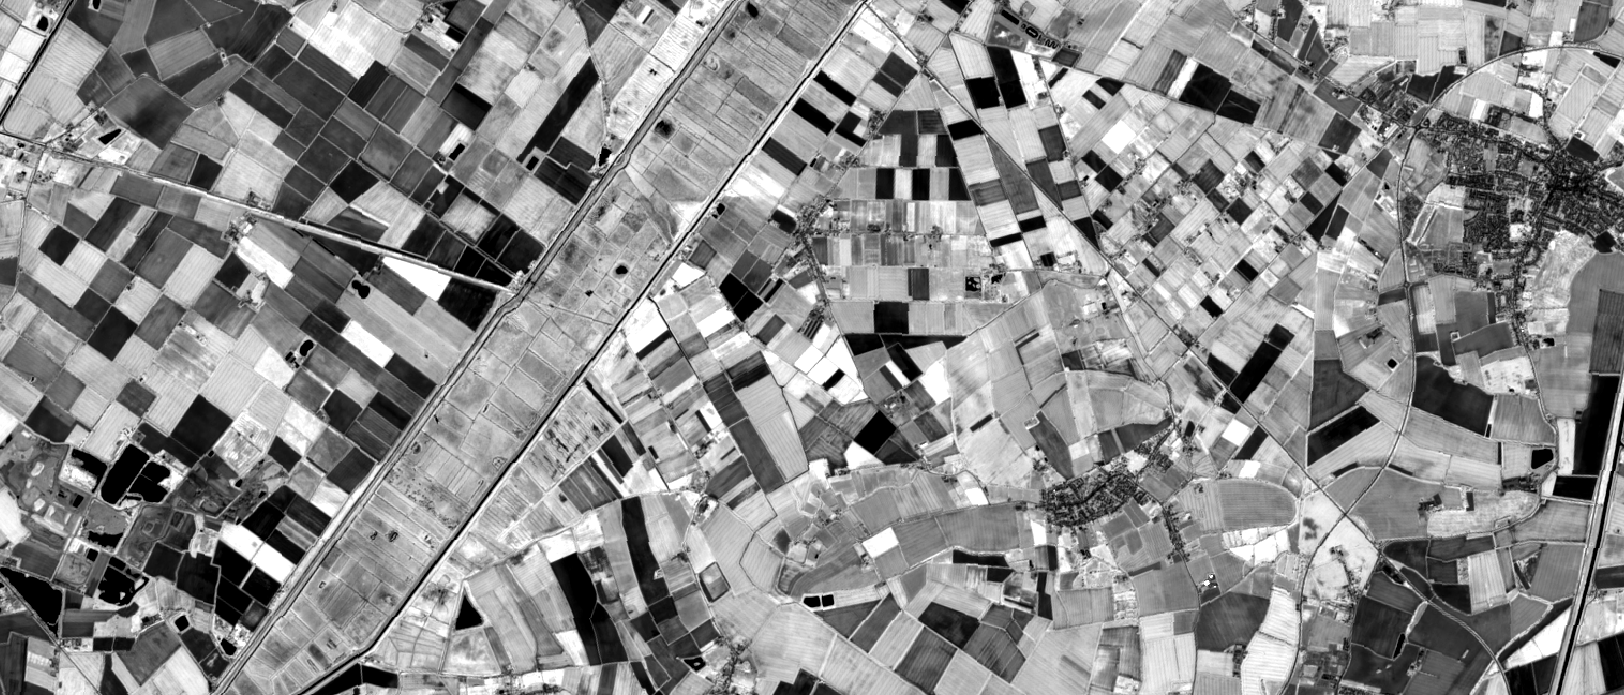

### 2023 06 15
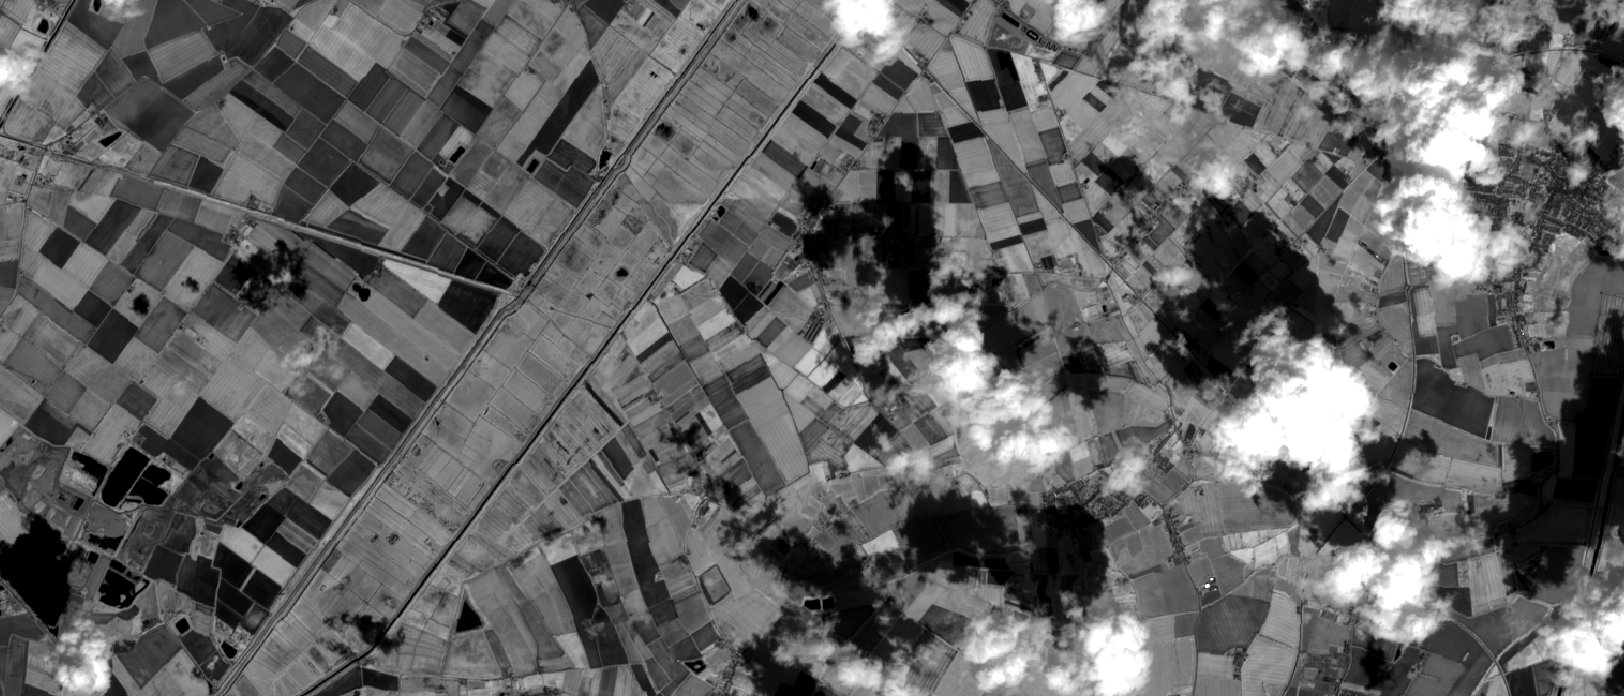

### 2023 06 25
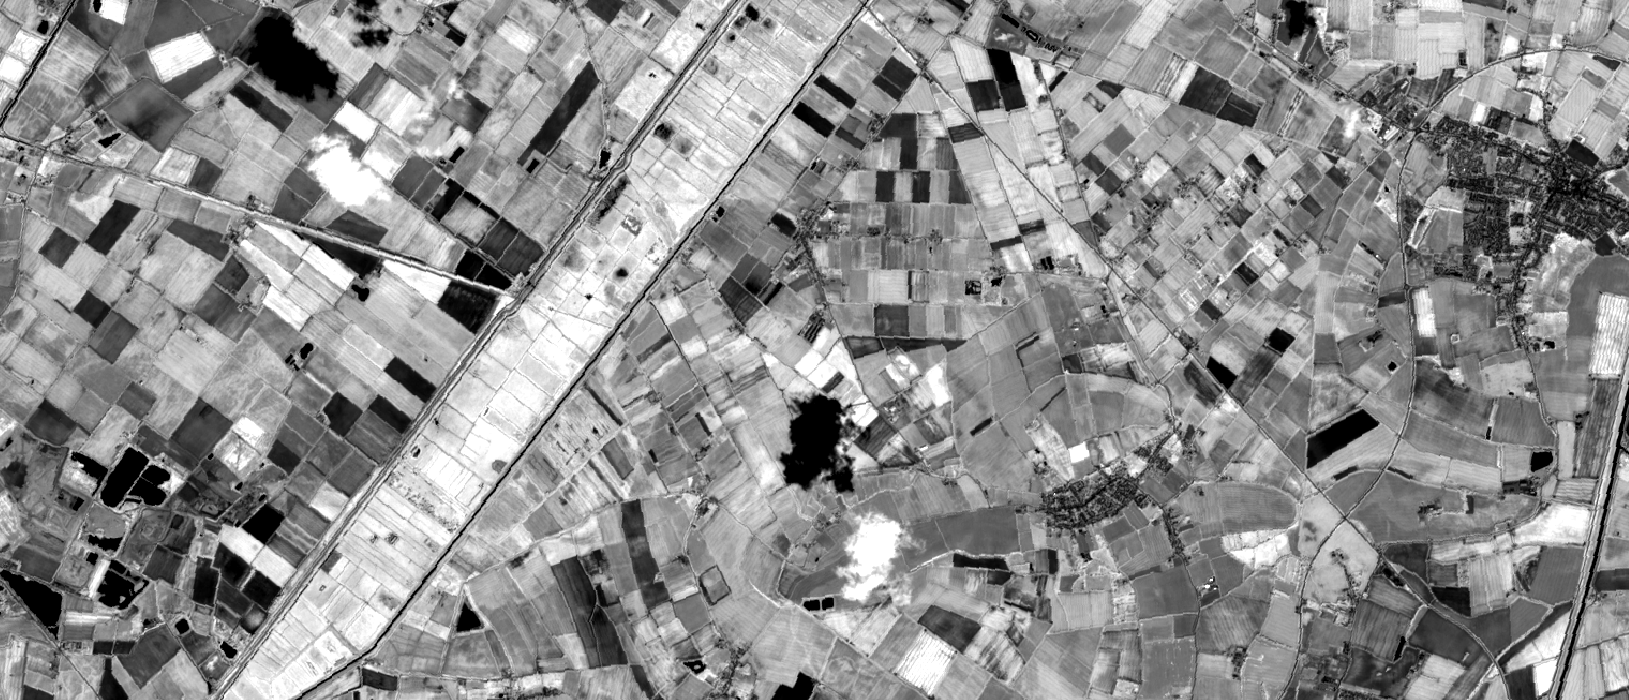

In [ ]:
! sudo apt install pktools
# input images need to overlap and be in the same EPSG
# -cr flag can be different mosaicing options
# bash commandline tool

! pkcomposite -i 20230610_B8_27700.tif -i 20230615_B8_27700.tif -i 20230625_B8_27700.tif -cr median -o composite_median.tif

### Output

Single band median composite

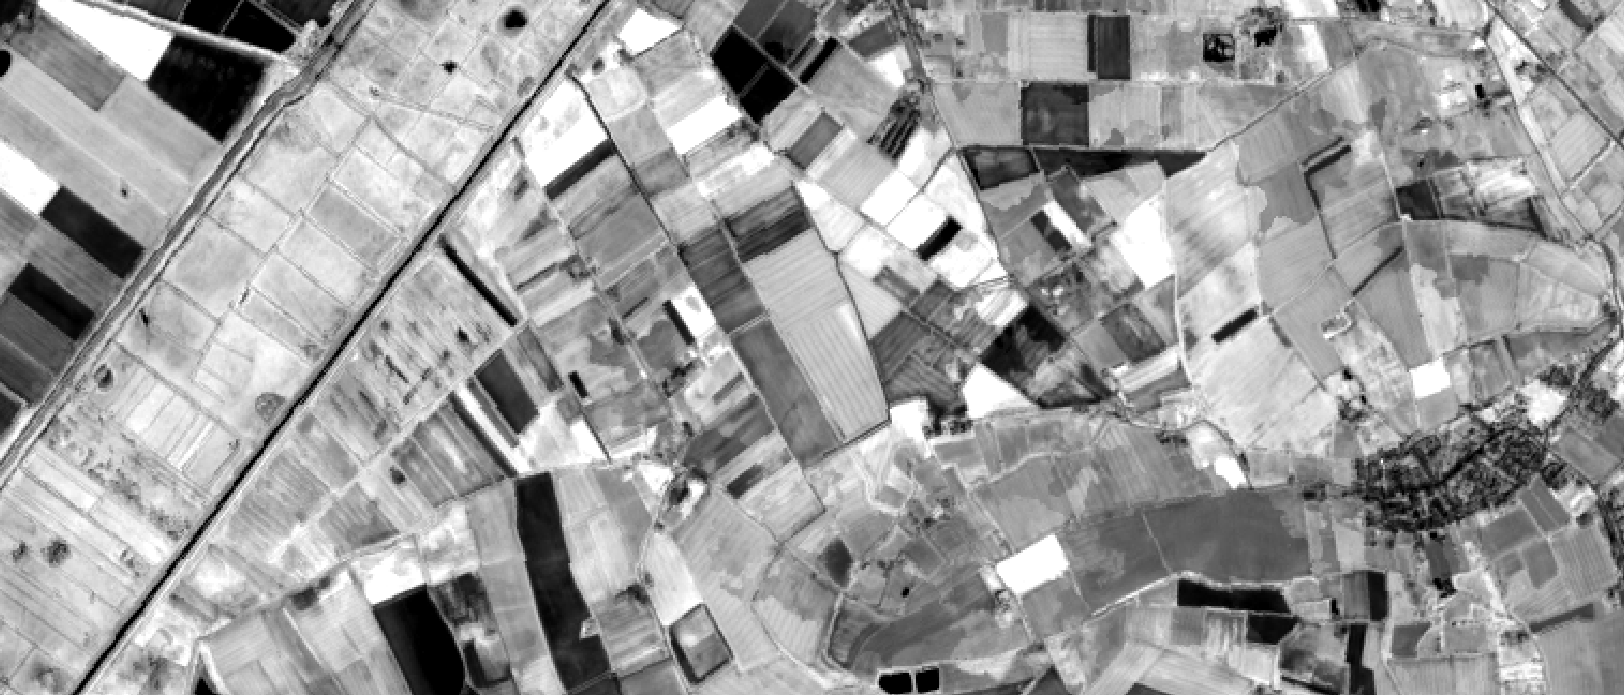

In [ ]:
## Update on use of pkcomposite

! pkcomposite -i test_4band_27700_A.tif -i test_4band_27700_B.tif -i test_4band_27700_C.tif -o test_b3.tif -cr mean -b 2 -e test_aoi_27700.geojson
# where -i is input data (4 band imagery), -o is the output image (single band composite), -cr is the composite method (e.g. mean, median etc), 
# -b is the band to be processed (zero indexed so this is band 3 in the 4-band input images), -e is the area of interest to clip to (we will need
# to input the AOI as a geojson). 

### Inputs and AOI

Three 4-band overlapping input images and AOI (red outline)

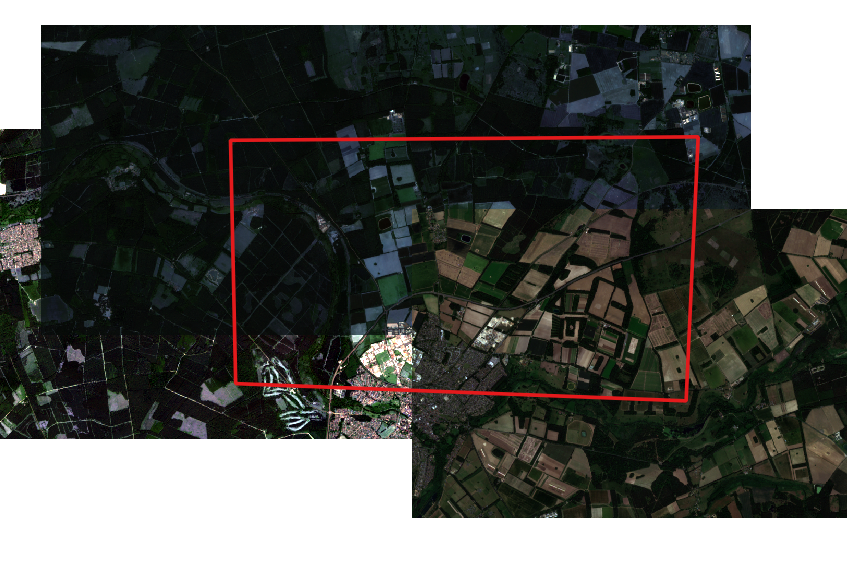

### Output

Single band output cropped to AOI

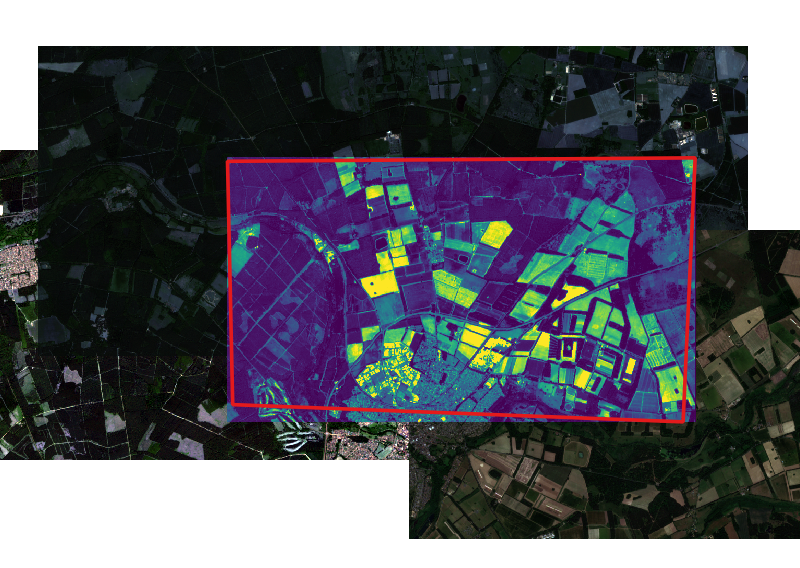

# PROCESS TO FOLLOW:

* pyeodh search of sentinel2_ard STAC (inputs are AOI polygon (we need this later) and date range (2023-04-01 - 2023-06-30 for the tests))
* STEP 1: for each band in each returned image apply the cloud mask to remove cloud pixels from the data
  * results in a multibanded image that is cloud-masked. 
  * need to retain information on original image capture date
  * output should be a temporary STAC catalog 
* STEP 2: for each cloud-masked image in a given month create band composites cropped to the AOI
  * I think some form of `pkcomposite -i in_A.tif -i in_B.tif -i in_C.tif -o out_b1.tif -cr median -b 0 -e aoi.geojson` should work
  * need to be able to supply all images, the aoi polygon, the composite method
  * output should be a STAC catalog of spatially cropped single-band composites for each month e.g. for a three month period and 4 band input data 
    there should be 3x b1 outputs, 3x b2 outputs, 3x b3 outputs, 3x b4 outputs  


# XARRAY??

Try to do the same with xarray and it throws up some error.

It's to do with the data format - need to sort this???


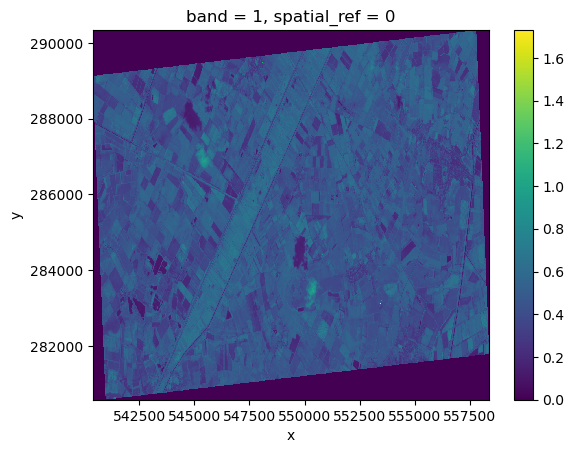

In [51]:
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt


# Load each satellite image using rioxarray
sat1 = rioxarray.open_rasterio('/home/al/Documents/EODH/Data/S2/20230610_B8_27700.tif')
sat2 = rioxarray.open_rasterio('/home/al/Documents/EODH/Data/S2/20230615_B8_27700.tif')
sat3 = rioxarray.open_rasterio('/home/al/Documents/EODH/Data/S2/20230625_B8_27700.tif')

sat1f = sat1/10000
sat2f = sat2/10000
sat3f = sat3/10000

# Combine the images into a single xarray Dataset along a new dimension (e.g., 'time')
stacked = xr.concat([sat1f, sat2f, sat3f], dim='band')
#stacked
#stacked = xr.concat([sat1, sat2], dim='band')
#stacked['band'] = [1, 2, 3]  # Label the bands

# Compute the median across the 'time' dimension
#median_image = stacked.median(dim='band')

# Export the median image as a new .tif file
#median_image.rio.to_raster('/home/al/Documents/EODH/Data/S2/xarray_median.tif')


# Check input data makes sense
sat3f.plot()
